In [5]:
"""
Patrick Brosseau 2023/04/11

spectroFROG_phase
"""
import os
import numpy as np
from numpy import mean
from numpy import std
from numpy.random import random, seed
from scipy.interpolate import UnivariateSpline
from scipy import interpolate
from scipy.ndimage import gaussian_filter,gaussian_filter1d
import matplotlib.pyplot as plt

from sklearn.datasets import make_regression
from sklearn.model_selection import RepeatedKFold, train_test_split
import tensorflow as tf

from tqdm import tqdm
import time
import glob

# Load data

Text(0, 0.5, 'Energy (eV)')

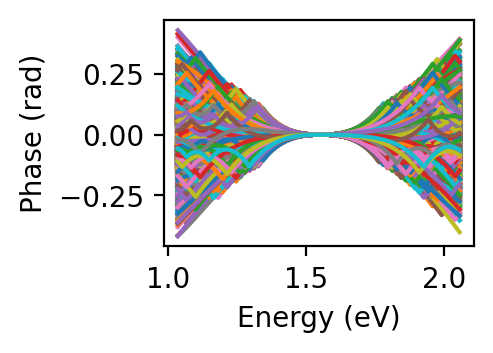

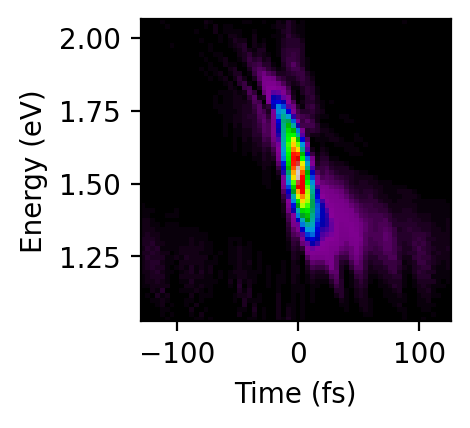

In [2]:
# np.savez("training_data.npz",training_full_set=training_full_set,label_full_set=label_full_set)
blocks = 8
training_full_set = []
label_full_set = []
for i in range(1,blocks+1):
    file = "training_data/training_data"+str(i)+".npz"
    dat = np.load(file)
    training_full_set.append(dat['training_set'])
    label_full_set.append(dat['label_set'])
    block_size = dat['training_set'].shape
training_full_set = np.reshape(np.array(training_full_set),[block_size[0]*blocks,block_size[1],block_size[2]])
label_full_set = np.reshape(np.array(label_full_set),[block_size[0]*blocks,block_size[1]])

ev = dat['ev']
t = dat['time']*1e15

plt.figure(figsize=(4/2,3/2),dpi=200)
plt.plot(ev,label_full_set.T)
plt.xlabel("Energy (eV)")
plt.ylabel("Phase (rad)")

plt.figure(figsize=(2,2),dpi=200)
plt.pcolormesh(t,ev,training_full_set[0], cmap="nipy_spectral")
plt.xlabel("Time (fs)")
plt.ylabel("Energy (eV)")

# Generate and train model

In [3]:
# Model
def get_model(n_inputs, n_outputs):
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.Conv2D(64, (3,3), padding="same",activation='relu', 
                                     input_shape=(64, 64, 1)))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(64, (3,3), padding="same",activation='relu'))
    model.add(tf.keras.layers.Dropout( 0.2))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(32, (3,3), padding="same",activation='relu',
                                     kernel_regularizer =tf.keras.regularizers.l2(l=0.00001)))
    model.add(tf.keras.layers.Dropout( 0.2))
    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='relu',
                                    kernel_regularizer =tf.keras.regularizers.l2(l=0.00001)))
    model.add(tf.keras.layers.Dense(64))
    
    model.compile(loss='mse', optimizer='adam',metrics="accuracy")
    return model

#Shuffle and split training_full_set into 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(training_full_set, label_full_set, 
                                                    test_size=0.2, random_state=42)
n_inputs, n_outputs = X_train.shape[1], y_train.shape[1]
print(n_inputs)
print(n_outputs)
model = get_model(n_inputs, n_outputs)

model.summary()

64
64
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)   

In [4]:
# Set checkpoing for saving model parameters during training
checkpoint_path = "checkpoints/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

filename=checkpoint_dir+'/log.csv'
history_logger=tf.keras.callbacks.CSVLogger(filename, separator=",", append=True)

batch_size = 125

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_freq=2*batch_size)


# Get the start time
st = time.time()
stp = time.process_time()

# Do the actual fitting
history = model.fit(X_train, 
                    y_train, 
                    verbose=1,
                    epochs=2,
                    validation_data=(X_test, y_test),
                    callbacks=[cp_callback,history_logger])

# Get the end time
etp = time.process_time()
et = time.time()

Epoch 1/2
125/125 [==============================] - 37s 283ms/step - loss: 0.0024 - accuracy: 0.0512 - val_loss: 0.0013 - val_accuracy: 0.0740
Epoch 2/2
124/125 [============================>.] - ETA: 0s - loss: 9.9480e-04 - accuracy: 0.0736
Epoch 2: saving model to checkpoints\cp.ckpt
125/125 [==============================] - 38s 301ms/step - loss: 9.9281e-04 - accuracy: 0.0740 - val_loss: 9.4554e-04 - val_accuracy: 0.1670


In [12]:
# get execution time
res = etp - stp
print('CPU Execution time:', res, 'seconds')
res = et - st
print('Wall time:', res, 'seconds')

CPU Execution time: 263.796875 seconds
Wall time: 74.51810431480408 seconds


# Verify Model Convergence

0.13699999451637268
32/32 [==============================] - 2s 66ms/step - loss: 8.4369e-04 - accuracy: 0.1200

Test accuracy: 0.11999999731779099


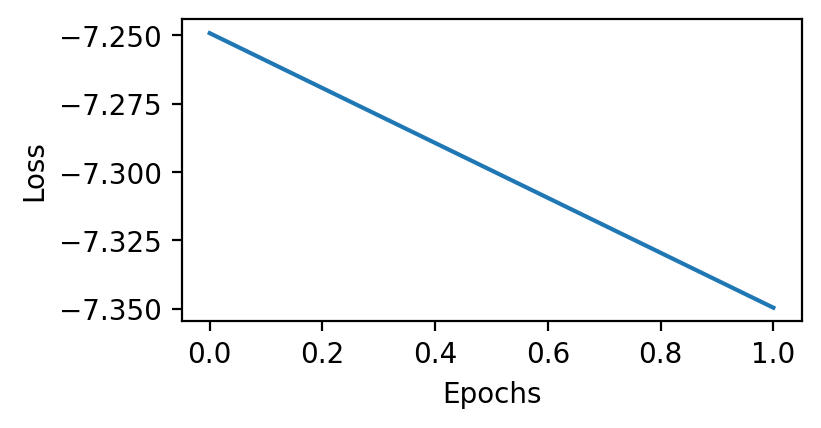

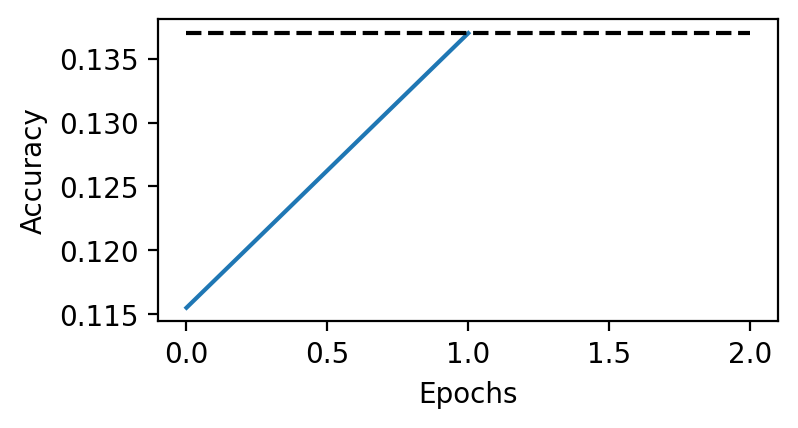

In [13]:
plt.figure(figsize=(4,2),dpi=200)
plt.plot(np.log(history.history['loss']))
plt.xlabel("Epochs")
plt.ylabel("Loss")
# plt.hlines(history.history['loss'][-1],0,len(history.history['loss']),color="k",linestyle="--")

plt.figure(figsize=(4,2),dpi=200)
plt.plot(history.history['accuracy'])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.hlines(history.history['accuracy'][-1],0,len(history.history['accuracy']),color="k",linestyle="--")
print(history.history['accuracy'][-1])

score = model.evaluate(X_test, y_test, verbose=1)
print('\nTest accuracy:', score[1])

# Validate Model

(1000, 64, 64)
1/1 [==============================] - 0s 35ms/step


Text(0, 0.5, 'Amplitude (a.u.)')

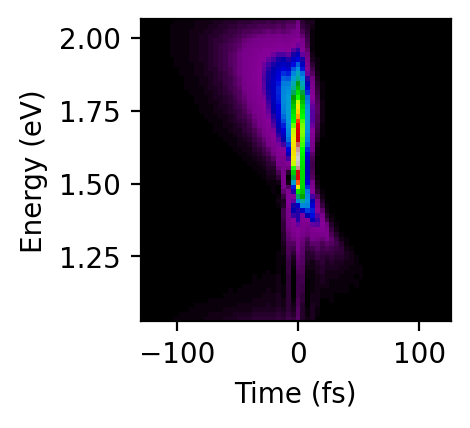

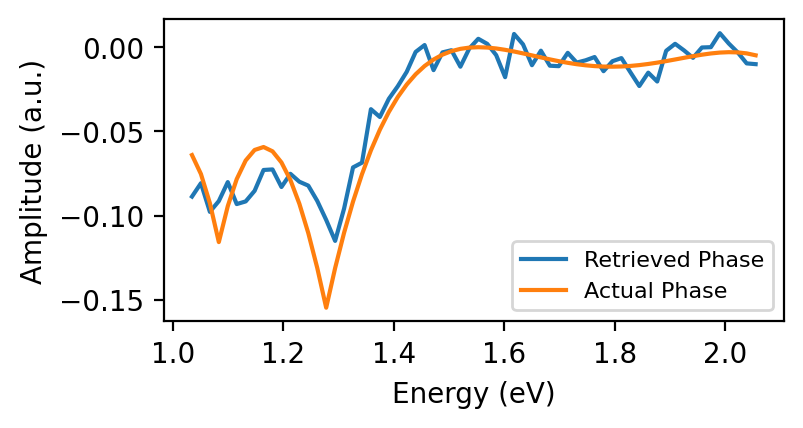

In [14]:
"""
Validate model with test data from earlier partition

1) Take test spectrum
2) Couple with ideal goal spectrum
3) Use model to predict the amplitude mask that would shape the test spectrum into the goal spectrum
4) Compare predicted mask to ideal mask
"""
print(X_test.shape)
test_ind = 715
test_FROG= X_test[test_ind,:,:] #get just the input spectrum for the test partition

row = test_FROG
newX = np.asarray([row])
newX = tf.convert_to_tensor(newX)
yhat = model.predict(newX)
# print('Predicted: %s' % yhat[0])

plt.figure(figsize=(2,2),dpi=200)
plt.pcolormesh(t,ev,test_FROG, cmap="nipy_spectral")
plt.xlabel("Time (fs)")
plt.ylabel("Energy (eV)")

plt.figure(figsize=(4,2),dpi=200)
plt.plot(ev,yhat[0][0:64],label="Retrieved Phase")
plt.plot(ev,y_test[test_ind][0:64],label="Actual Phase")
plt.legend(fontsize=8)
plt.xlabel("Energy (eV)")
plt.ylabel("Amplitude (a.u.)")

# Load and plot saved model

In [15]:
checkpoint_path = "checkpoints/cp.ckpt"#"training_1/cp.ckpt"
# checkpoint_path = "training_azureGPU/cp.ckpt"#"training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

model.load_weights(checkpoint_path)

13.699999451637268
32/32 [==============================] - 2s 68ms/step - loss: 8.4369e-04 - accuracy: 0.1200

Test accuracy: 11.999999731779099


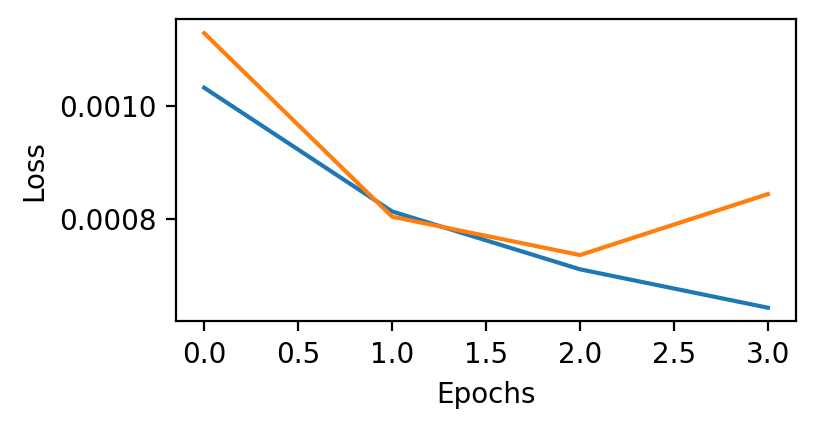

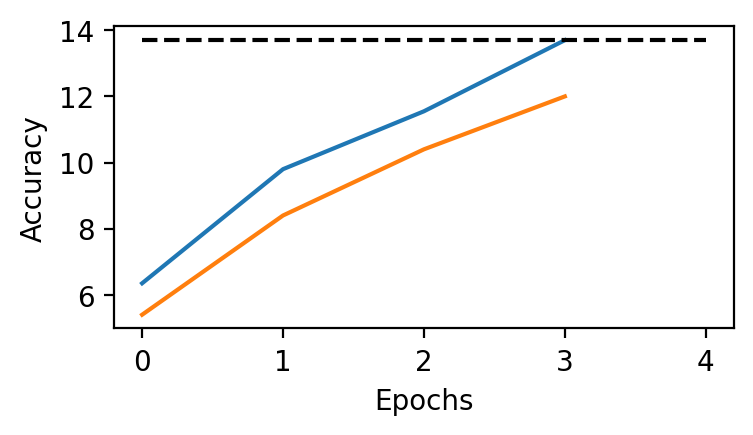

In [16]:
dat = np.loadtxt(checkpoint_dir+"/log.csv",skiprows=1,delimiter=",")
history = {"epoch": dat[:,0],"accuracy": dat[:,1],"loss": dat[:,2],"val_acc": dat[:,3],"val_loss": dat[:,4]}

plt.figure(figsize=(4,2),dpi=200)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
# plt.ylim(-10,-7)
# plt.hlines(np.average(history['val_loss'][-10::]),0,100,color="k",linestyle="--")
# plt.hlines(history['loss'][-1],0,100,color="k",linestyle="--")
# plt.xlim(0,100)

plt.figure(figsize=(4,2),dpi=200)
plt.plot(100*history['accuracy'])
plt.plot(100*history['val_acc'])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.hlines(100*history['accuracy'][-1],0,len(history['accuracy']),color="k",linestyle="--")
# plt.xlim(0,100)
print(100*history['accuracy'][-1])

score = model.evaluate(X_test, y_test, verbose=1)
print('\nTest accuracy:', 100*score[1])

13.699999451637268
32/32 [==============================] - 2s 69ms/step - loss: 8.4369e-04 - accuracy: 0.1200

Test accuracy: 11.999999731779099


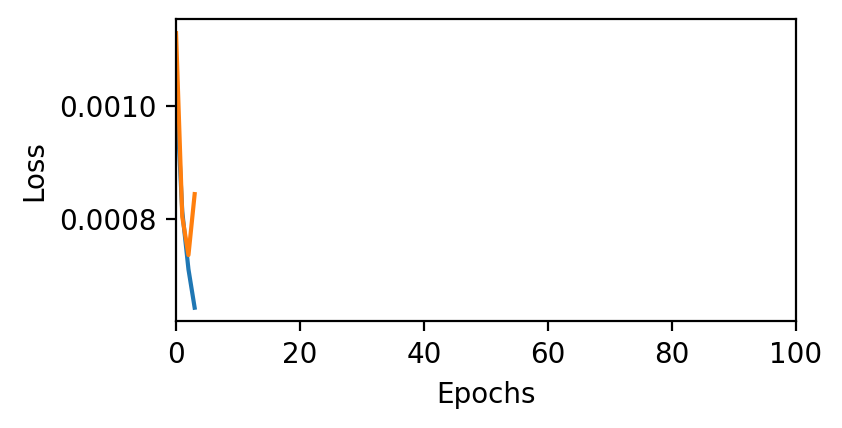

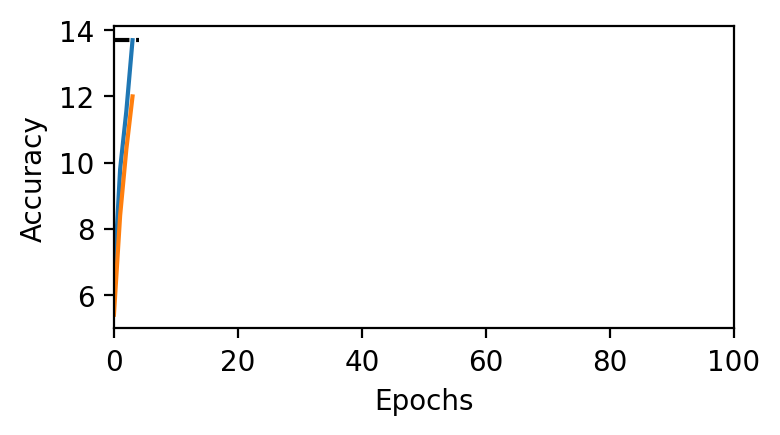

In [17]:
dat = np.loadtxt(checkpoint_dir+"/log.csv",skiprows=1,delimiter=",")
history = {"epoch": dat[:,0],"accuracy": dat[:,1],"loss": dat[:,2],"val_acc": dat[:,3],"val_loss": dat[:,4]}

plt.figure(figsize=(4,2),dpi=200)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
# plt.ylim(-10,-7)
# plt.hlines(np.average(np.log(history['val_loss'][-10::])),0,100,color="k",linestyle="--")
# plt.hlines(np.log(history['loss'][-1]),0,100,color="k",linestyle="--")
plt.xlim(0,100)

plt.figure(figsize=(4,2),dpi=200)
plt.plot(100*history['accuracy'])
plt.plot(100*history['val_acc'])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.hlines(100*history['accuracy'][-1],0,len(history['accuracy']),color="k",linestyle="--")
plt.xlim(0,100)
print(100*history['accuracy'][-1])

score = model.evaluate(X_test, y_test, verbose=1)
print('\nTest accuracy:', 100*score[1])

1/1 [==============================] - 0s 33ms/step


Text(0, 0.5, 'Energy (eV)')

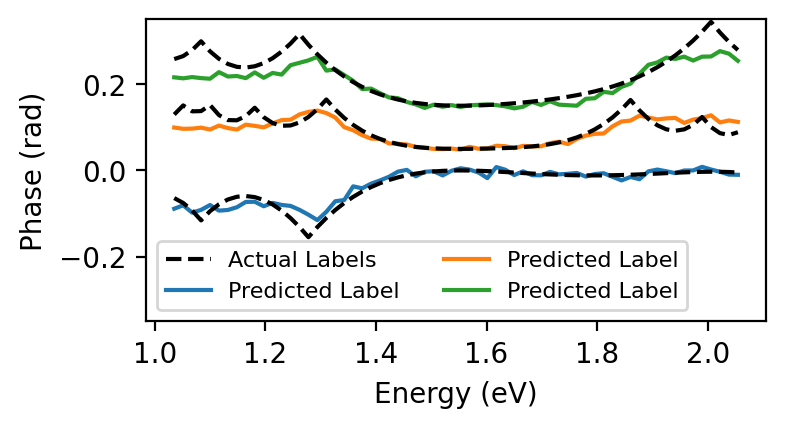

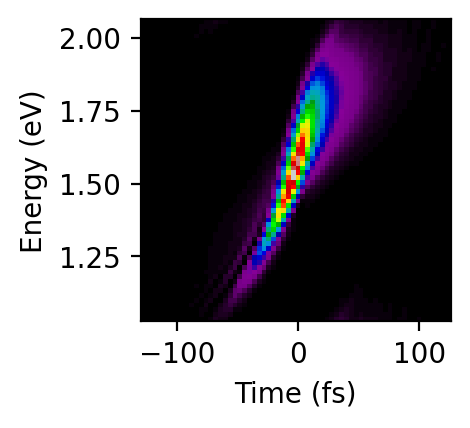

In [18]:
plt.figure(figsize=(4,2),dpi=200)
test_ind = 715
test_FROG= X_test[test_ind,:,:] #get just the input spectrum for the test partition

row = test_FROG
newX = np.asarray([row])
newX = tf.convert_to_tensor(newX)
yhat = model.predict(newX)

plt.plot(ev,y_test[test_ind][0:64],label="Actual Labels",c="k",linestyle="dashed",zorder=10)
plt.plot(ev,yhat[0][0:64],label="Predicted Label")


test_ind = 716
test_FROG= X_test[test_ind,:,:] #get just the input spectrum for the test partition

row = test_FROG
newX = np.asarray([row])
newX = tf.convert_to_tensor(newX)
yhat = model.predict(newX)

plt.plot(ev,0.05+yhat[0][0:64],label="Predicted Label")
plt.plot(ev,0.05+y_test[test_ind][0:64],c="k",linestyle="dashed")


test_ind = 720
test_FROG= X_test[test_ind,:,:] #get just the input spectrum for the test partition

row = test_FROG
newX = np.asarray([row])
newX = tf.convert_to_tensor(newX)
yhat = model.predict(newX)

plt.plot(ev,0.15+yhat[0][0:64],label="Predicted Label")
plt.plot(ev,0.15+y_test[test_ind][0:64],c="k",linestyle="dashed")

plt.ylim(-0.35,0.35)
plt.legend(fontsize=8,ncol=2)
plt.xlabel("Energy (eV)")
plt.ylabel("Phase (rad)")


plt.figure(figsize=(2,2),dpi=200)
plt.pcolormesh(t,ev,test_FROG, cmap="nipy_spectral")
plt.xlabel("Time (fs)")
plt.ylabel("Energy (eV)")

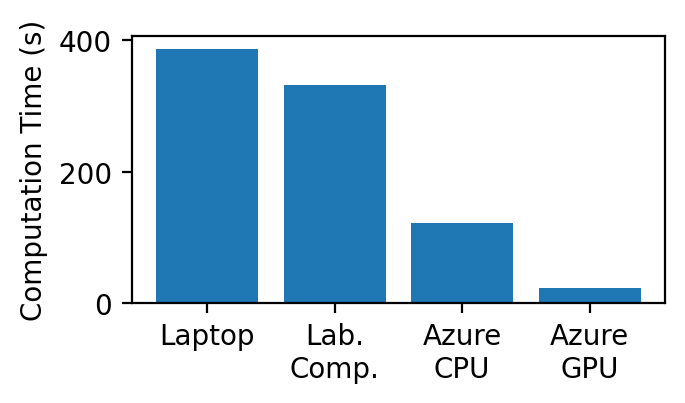

In [19]:
fig = plt.figure(figsize=(4/1.5,2/1.5),dpi=200)
ax = fig.add_axes([0,0,1,1])
comps = ['Laptop','Lab.\nComp.','Azure\nCPU','Azure\nGPU']
comp_time = [386.6,332,122,22.6]
ax.bar(comps,comp_time)
plt.ylabel("Computation Time (s)")
# plt.ylim(0,180)
plt.show()